In [0]:
!pip install InstagramApi

     |████████████████████████████████| 522kB 4.2MB/s 
     |████████████████████████████████| 61kB 9.9MB/s 
     |████████████████████████████████| 133kB 54.6MB/s 
     |████████████████████████████████| 51kB 8.4MB/s 
     |████████████████████████████████| 3.3MB 56.0MB/s 
  Created wheel for InstagramApi: filename=InstagramAPI-1.0.2-cp36-none-any.whl size=14020 sha256=b7e6fc41f18a9a286037e2c462afec3dc8edf3a8f8e60cb3bdb244d3058e6c73
  Stored in directory: /root/.cache/pip/wheels/6c/00/8f/ff713f248704d409ad2c2fc1352ce62b2b4d7d12a75267a911
  Created wheel for imageio: filename=imageio-2.1.2-cp36-none-any.whl size=3248800 sha256=c547ccbbeb2a4482f39905ea6da6456f25b01ad1e8b190cc13b23a84eeafc801
  Stored in directory: /root/.cache/pip/wheels/46/d7/61/fe435bf3dc20403ff38ffed213528ae710b4301ac6b403c582
Successfully built InstagramApi imageio
ERROR: tensorflow-datasets 2.1.0 has requirement requests>=2.19.0, but you'll have requests 2.11.1 which is incompatible.
ERROR: spacy 2.2.4 has requirem

In [0]:
from pandas.io.json import json_normalize

In [0]:
import pprint
from time import sleep
from InstagramAPI import InstagramAPI
import pandas as pd


users_list = []
following_users = []
follower_users = []

class InstaBot:

    def __init__(self):
        self.api = InstagramAPI("Username", "Password")
        self.api.USER_AGENT = 'Instagram 10.34.0 Android (18/4.3; 320dpi; 720x1280; Xiaomi; HM 1SW; armani; qcom; en_US)'

    def get_my_profile_details():
        api.login() 
        api.getSelfUsernameInfo()
        result = api.LastJson
        username = result['user']['username']
        full_name = result['user']['full_name']
        profile_pic_url = result['user']['profile_pic_url']
        followers = result['user']['follower_count']
        following = result['user']['following_count']
        media_count = result['user']['media_count']
        df_profile = pd.DataFrame(
            {'username':username,
            'full name': full_name,
            'profile picture URL':profile_pic_url,
            'followers':followers,
            'following':following,
            'media count': media_count,
            }, index=[0])
        df_profile.to_csv('profile.csv', sep='\t', encoding='utf-8')

    def get_my_feed():
        image_urls = []
        api.login()
        api.getSelfUserFeed()
        result = api.LastJson
        # formatted_json_str = pprint.pformat(result)
        # print(formatted_json_str)
        if 'items' in result.keys():
            for item in result['items'][0:5]:
                if 'image_versions2' in item.keys():
                    image_url = item['image_versions2']['candidates'][1]['url']
                    image_urls.append(image_url)

        df_feed = pd.DataFrame({
                    'image URL':image_urls
                })
        df_feed.to_csv('feed.csv', sep='\t', encoding='utf-8')
    
    def get_likes_list(self,username):
        api = self.api
        api.login()
        api.searchUsername(username) #Gets most recent post from user
        result = api.LastJson
        username_id = result['user']['pk']
        user_posts = api.getUserFeed(username_id)
        result = api.LastJson
        media_id = result['items'][0]['id']

        api.getMediaLikers(media_id)
        users = api.LastJson['users']
        for user in users:
            users_list.append({'pk':user['pk'], 'username':user['username']})
        bot.follow_users(users_list)


    def follow_users(self,users_list):
        api = self.api
        api.login()
        api.getSelfUsersFollowing()
        result = api.LastJson
        for user in result['users']:
            following_users.append(user['pk'])
        for user in users_list:
            if not user['pk'] in following_users:
                print('Following @' + user['username'])
                api.follow(user['pk'])
                # set this really long to avoid from suspension
                # sleep(20)
            else:
                print('Already following @' + user['username'])
                # sleep(10)

    def get_posts_likers(self, my_posts):
        '''Retrieve all likers on all posts'''
        
        likers = []
        
        print('wait %.1f minutes' % (len(my_posts)*2/60.))
        for i in range(len(my_posts)):
            m_id = my_posts[i]['id']
            self.api.getMediaLikers(m_id)
            
            likers += [self.api.LastJson]
            
            # Include post_id in likers dict list
            likers[i]['post_id'] = m_id
            
            #time.sleep(2)
        print('done')
        
        return likers

    def get_my_posts(self):
        '''Retrieve all posts from own profile'''
        my_posts = []
        has_more_posts = True
        max_id= ''

        while has_more_posts:
            self.api.getSelfUserFeed(maxid=max_id)
            if self.api.LastJson['more_available'] is not True:
                has_more_posts = False #stop condition

            max_id = self.api.LastJson.get('next_max_id','')
            #release_date = api.LastJson.get()
            my_posts.extend(self.api.LastJson['items']) #merge lists
            #time.sleep(2) # slows down to avoid flooding

            if has_more_posts:
                print(str(len(my_posts)) + ' posts retrieved so far...')

        print('Total posts retrieved: ' + str(len(my_posts)))
        
        return my_posts

    def get_posts_commenters(self, my_posts):
        '''Retrieve all commenters on all posts '''
        
        commenters = []
        
        print('wait %.1f minutes' % (len(my_posts)*2/60.))
        for i in range(len(my_posts)):
            m_id = my_posts[i]['id']
            self.api.getMediaComments(m_id)
            
            commenters += [self.api.LastJson]
            
            # Include post_id in commenters dict list
            commenters[i]['post_id'] = m_id
                
            #time.sleep(2)
        print('done')
        
        return commenters

    def posts_likers_to_df(self, likers):
        '''Transforms likers list of dicts into pandas DataFrame'''
        
        # Normalize likers by getting the 'users' list and the post_id of each like
        df_likers = json_normalize(likers, 'users', ['post_id'])
        
        # Add 'content_type' column to know the rows are likes
        df_likers['content_type'] = 'like'
        
        return df_likers

    def posts_commenters_to_df(self, commenters):
        '''Transforms commenters list of dicts into pandas DataFrame'''
        
        # Include username and full_name of commenter in 'comments' list of dicts
        for i in range(len(commenters)):
            if len(commenters[i]['comments']) > 0: # checks if there is any comment on the post
                for j in range(len(commenters[i]['comments'])):
                    # Puts username/full_name one level up
                    commenters[i]['comments'][j]['username'] = commenters[i]['comments'][j]['user']['username']
                    commenters[i]['comments'][j]['full_name'] = commenters[i]['comments'][j]['user']['full_name']
                    
        # Create DataFrame
        # Normalize commenters to have 1 row per comment, and gets 'post_id' from parent 
        df_commenters = json_normalize(commenters, 'comments', 'post_id')
        
        # Get rid of 'user' column as we already handled it above
        #del df_commenters['user']
        
        return df_commenters

    def unfollow_users(self):
        api = self.api
        api.login()
        api.getSelfUserFollowers()
        result = api.LastJson
        for user in result['users']:
            follower_users.append({'pk':user['pk'], 'username':user['username']})

        api.getSelfUsersFollowing()
        result = api.LastJson
        for user in result['users']:
            following_users.append({'pk':user['pk'],'username':user['username']})

        for user in following_users:
            if not user['pk'] in [user['pk'] for user in follower_users]:
                print('Unfollowing @' + user['username'])
                api.unfollow(user['pk'])
                # set this really long to avoid from suspension
                # sleep(20) 



In [0]:

bot =  InstaBot()
# To follow users run the function below
# change the username ('instagram') to your target username
bot.get_likes_list('p1halani')

Request return 429 error!
{'message': 'Please wait a few minutes before you try again.', 'status': 'fail'}
Request return 405 error!
{'message': '', 'status': 'fail'}
Login success!

Already following @bhaggu_2509
Already following @_dharti28
Already following @zineadas
Already following @nish_1289
Already following @shifa_8299
Already following @dungeon_master08
Already following @_yell0w.su6marine_
Already following @_nancyism_
Already following @ana.sarkar11
Already following @1011kari
Already following @thakkar1548
Already following @error_404.0
Already following @vashistha.mohit
Already following @gayatri.jaiswal18
Already following @sujit_ry
Already following @bibek.goswami.31
Already following @priyankashah1907
Already following @suranaritika1
Already following @parakhpreksha
Already following @neelavdeep10
Already following @vajrakrishnam
Already following @busi_reddy_karnati
Already following @abhirish1
Already following @thedeepakkahar
Already following @neha_bora0305
Already

In [0]:
my_posts =bot.get_my_posts()

Total posts retrieved: 8


In [0]:
likers = bot.get_posts_likers(my_posts)

wait 0.3 minutes
done


In [0]:
commenters = bot.get_posts_commenters(my_posts)

wait 0.3 minutes
done


In [0]:
df_likers = bot.posts_likers_to_df(likers)
df_commenters = bot.posts_commenters_to_df(commenters)

In [0]:
# created_at
print('Total likes on profile: ' + str(df_likers.shape[0])) #shape[0] represents number of rows

Total likes on profile: 392


In [0]:
print('Total posts: ' + str(len(my_posts)))
print('---------')
print('Total likes on profile: ' + str(df_likers.shape[0])) #shape[0] represents number of rows
print('Distinct users that liked your posts: ' +str(df_likers.username.nunique())) # nunique() will count distinct values of a col
print('---------')
print('Total comments on profile: ' + str(df_commenters.shape[0]))
print('Distinct users that commented your posts: ' +str(df_commenters.username.nunique()))

Total posts: 8
---------
Total likes on profile: 392
Distinct users that liked your posts: 148
---------
Total comments on profile: 21
Distinct users that commented your posts: 10


In [0]:
# As each row represents a like, we can perform a value_counts on username and slice it to the first 10 items (pandas already order it for us)
df_likers.username.value_counts()[:10]

_dharti28            8
pushpak_tay          8
dungeon_master08     8
viralhalani          7
palkeshsaklecha      7
rajingale1024        6
akash_dhanesha       6
neha_bora0305        6
dhawal.dc            6
_nikitatoshniwal_    6
Name: username, dtype: int64

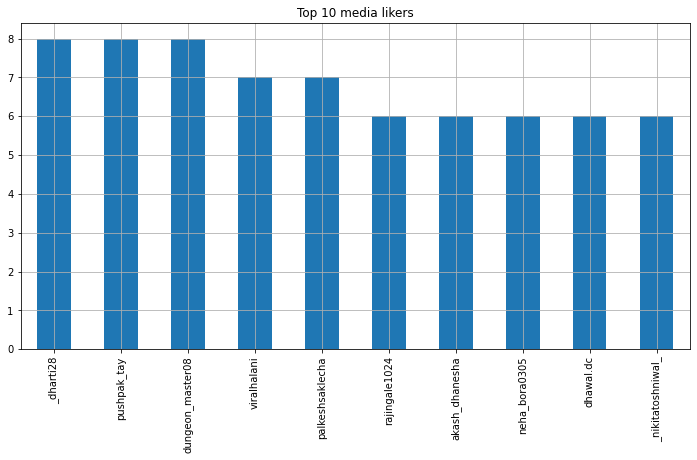

In [0]:
df_likers.username.value_counts()[:10].plot(kind='bar', title='Top 10 media likers', grid=True, figsize=(12,6))

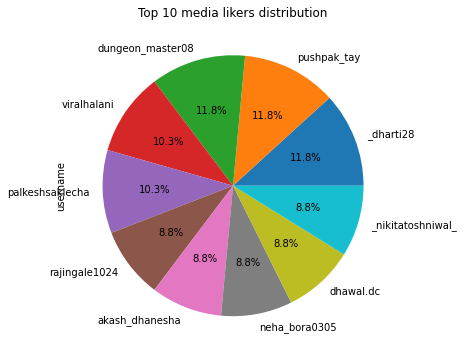

In [0]:
df_likers.username.value_counts()[:10].plot(kind='pie', title='Top 10 media likers distribution', autopct='%1.1f%%', figsize=(12,6))